In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день:
Будет дождь, если rainfall >=1

In [3]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df.shape

(145460, 23)

Удалим столбцы

In [5]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [6]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [7]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

<ipython-input-7-062454651978>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
<ipython-input-7-062454651978>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
<ipython-input-7-0

In [8]:
df[df['RainTomorrow']==0.0].count()

,0
Rainfall,97103
Humidity3pm,97103
Pressure9am,97103
RainToday,97103
RainTomorrow,97103


In [9]:
df[df['RainTomorrow']==1.0].count()

,0
Rainfall,27586
Humidity3pm,27586
Pressure9am,27586
RainToday,27586
RainTomorrow,27586


Классы несбалансированы

In [10]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [11]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [12]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)

    # torch.nn.init.xavier_uniform_(self.fc1.weight)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [13]:
criterion = nn.BCELoss()

In [14]:
device = torch.device( "cpu")

In [15]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [16]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [17]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)

    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628505706787, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720740556716919, accuracy: 0.7959740161895752
    
epoch 200
    Test  set - loss: 0.5436038970947266, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333549380302429, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.5154793858528137, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.48074430227279663, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.4678133726119995, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.455722838640213, accuracy: 0.784826397895813
    
epoch 800
    Test  set - loss: 0.4443385899066925, accuracy: 0.7912423014640808
    
epoch 900
    Test  set - loss: 0.433512419462204, accuracy: 0.7987408638000488
    
epoch 1000
    Test  set - loss: 0.4240734279155731, accuracy: 0.8106504082679749
    
epoch 1100
    Test  set - loss: 0.41709357500076294, accu

In [18]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [19]:
net = torch.load(MODEL_PATH)

<ipython-input-19-58455d427580>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [20]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



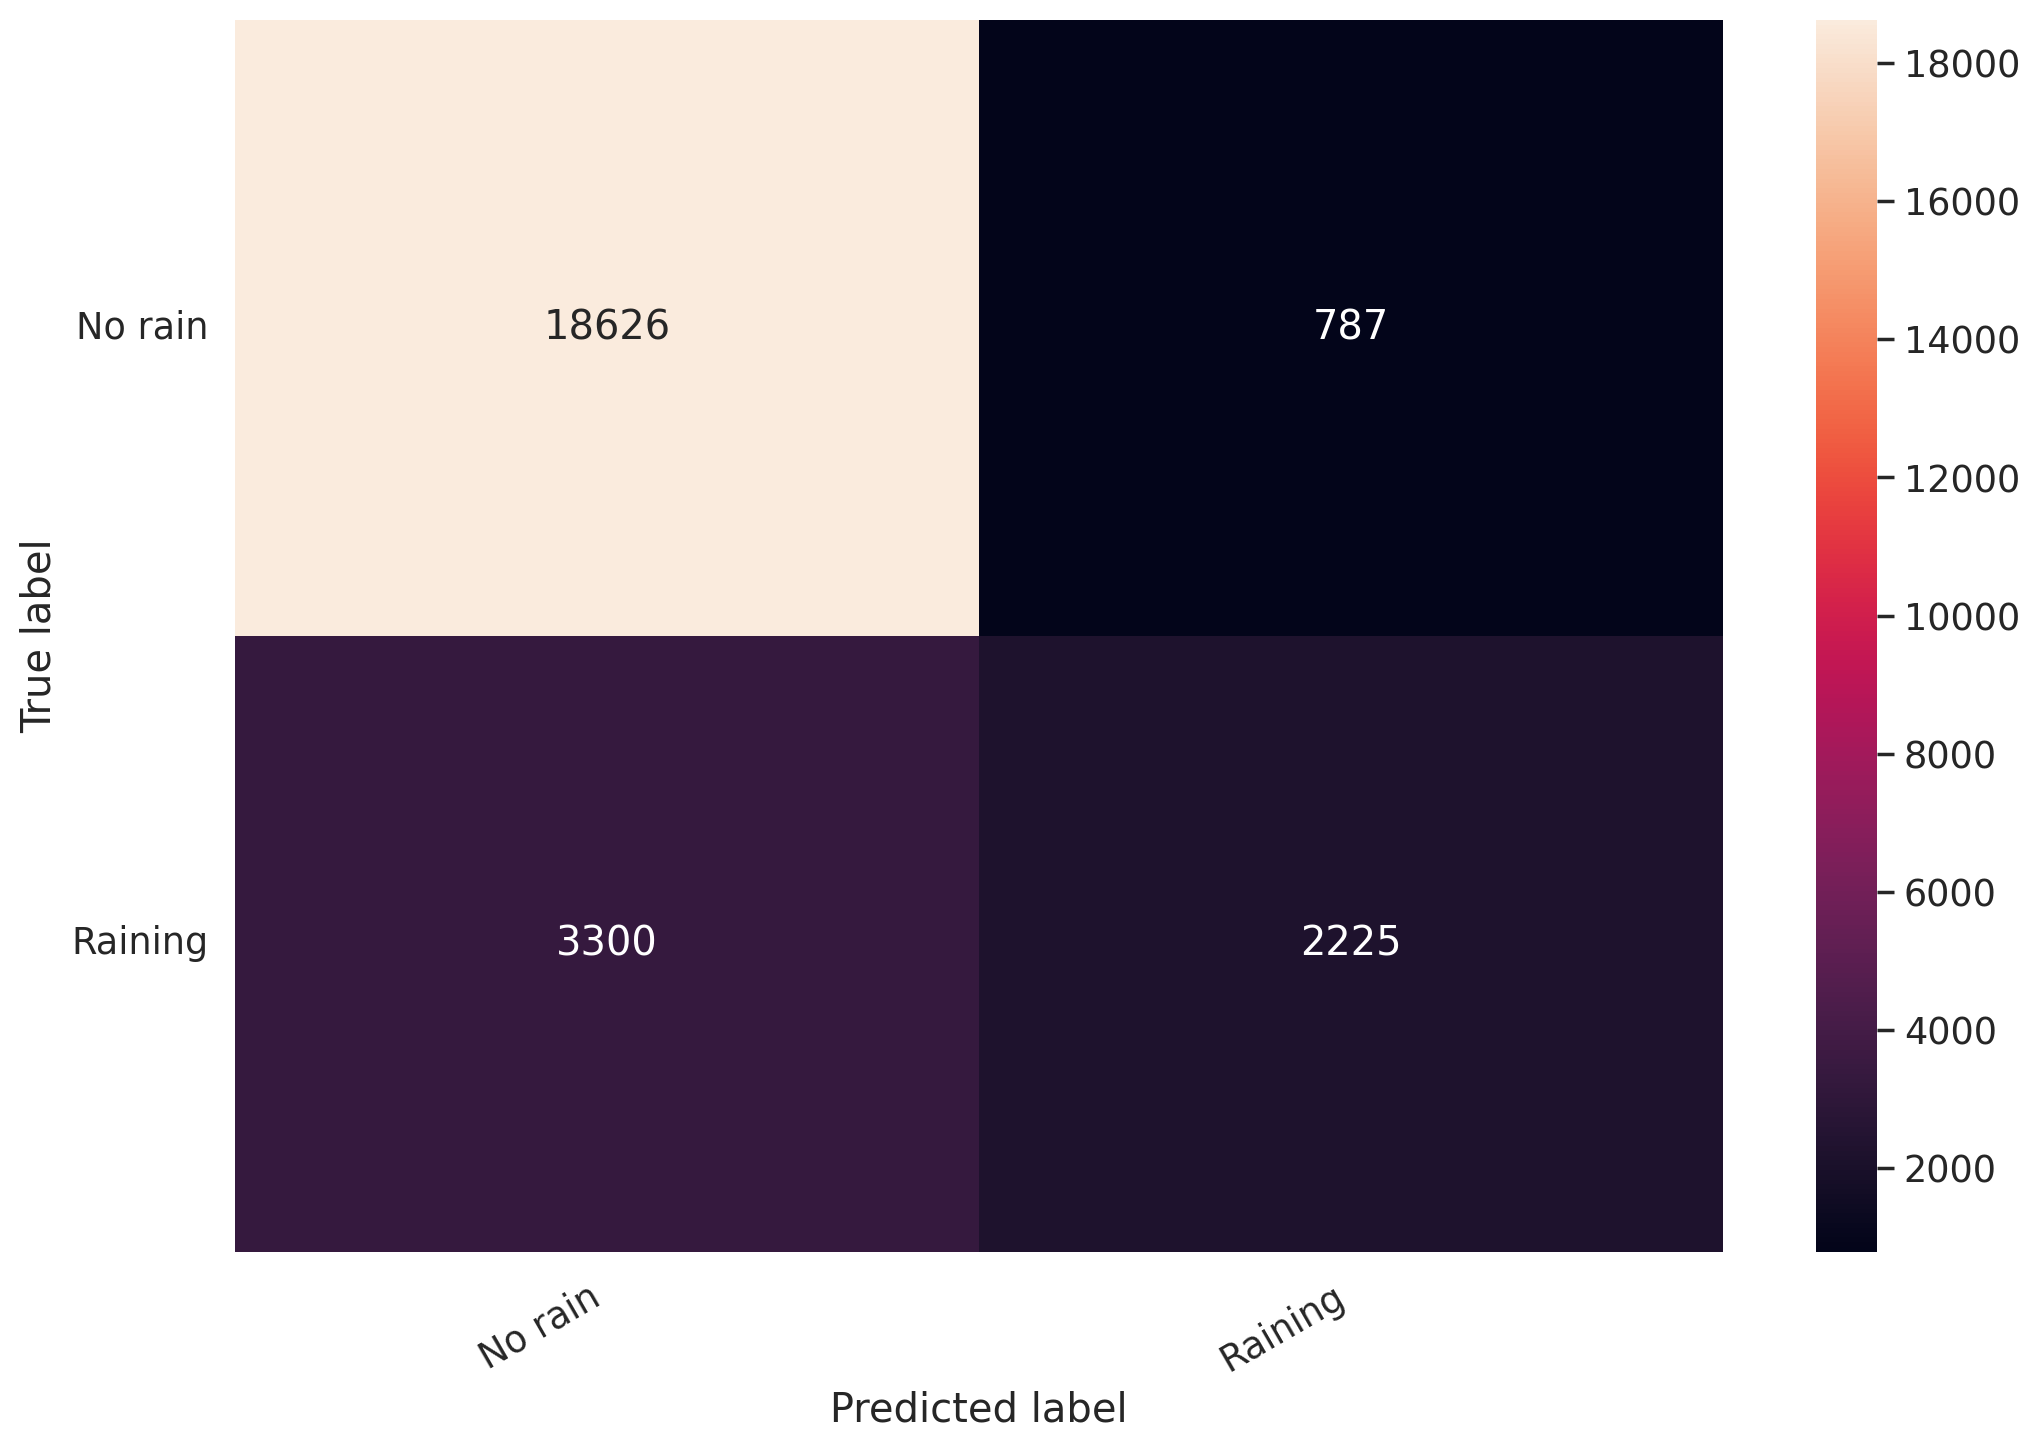

In [21]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate,
# выберите оптимальное значение.

# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.

#1 задание

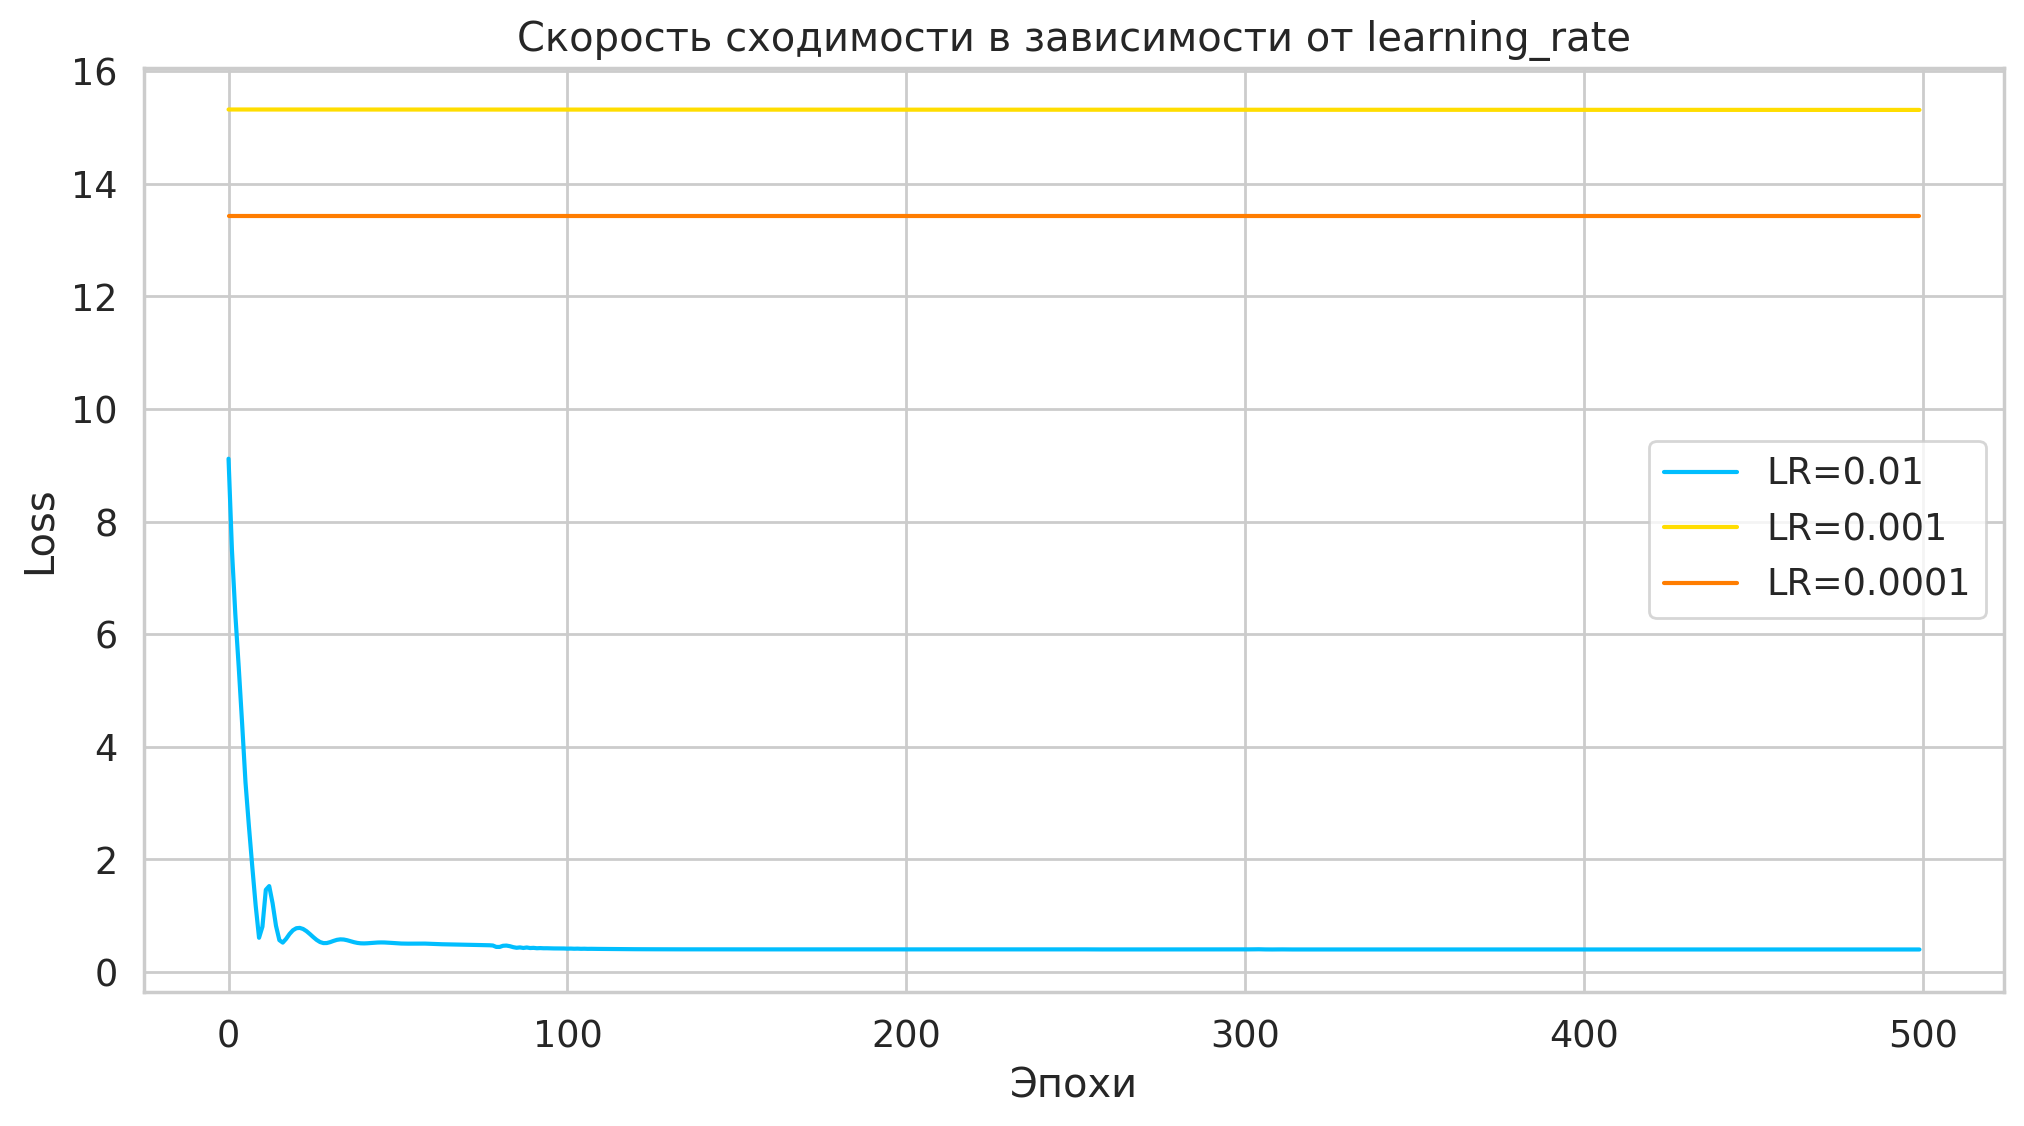

In [29]:
learning_rates = [0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    net = Net(4).to(device)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.BCELoss()
    losses = []

    for epoch in range(500):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        losses.append(train_loss.item())

    results[lr] = losses

# Построим график
plt.figure(figsize=(12, 6))
for lr, loss in results.items():
    plt.plot(loss, label=f'LR={lr}')
plt.title('Скорость сходимости в зависимости от learning_rate')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()


#2 задание

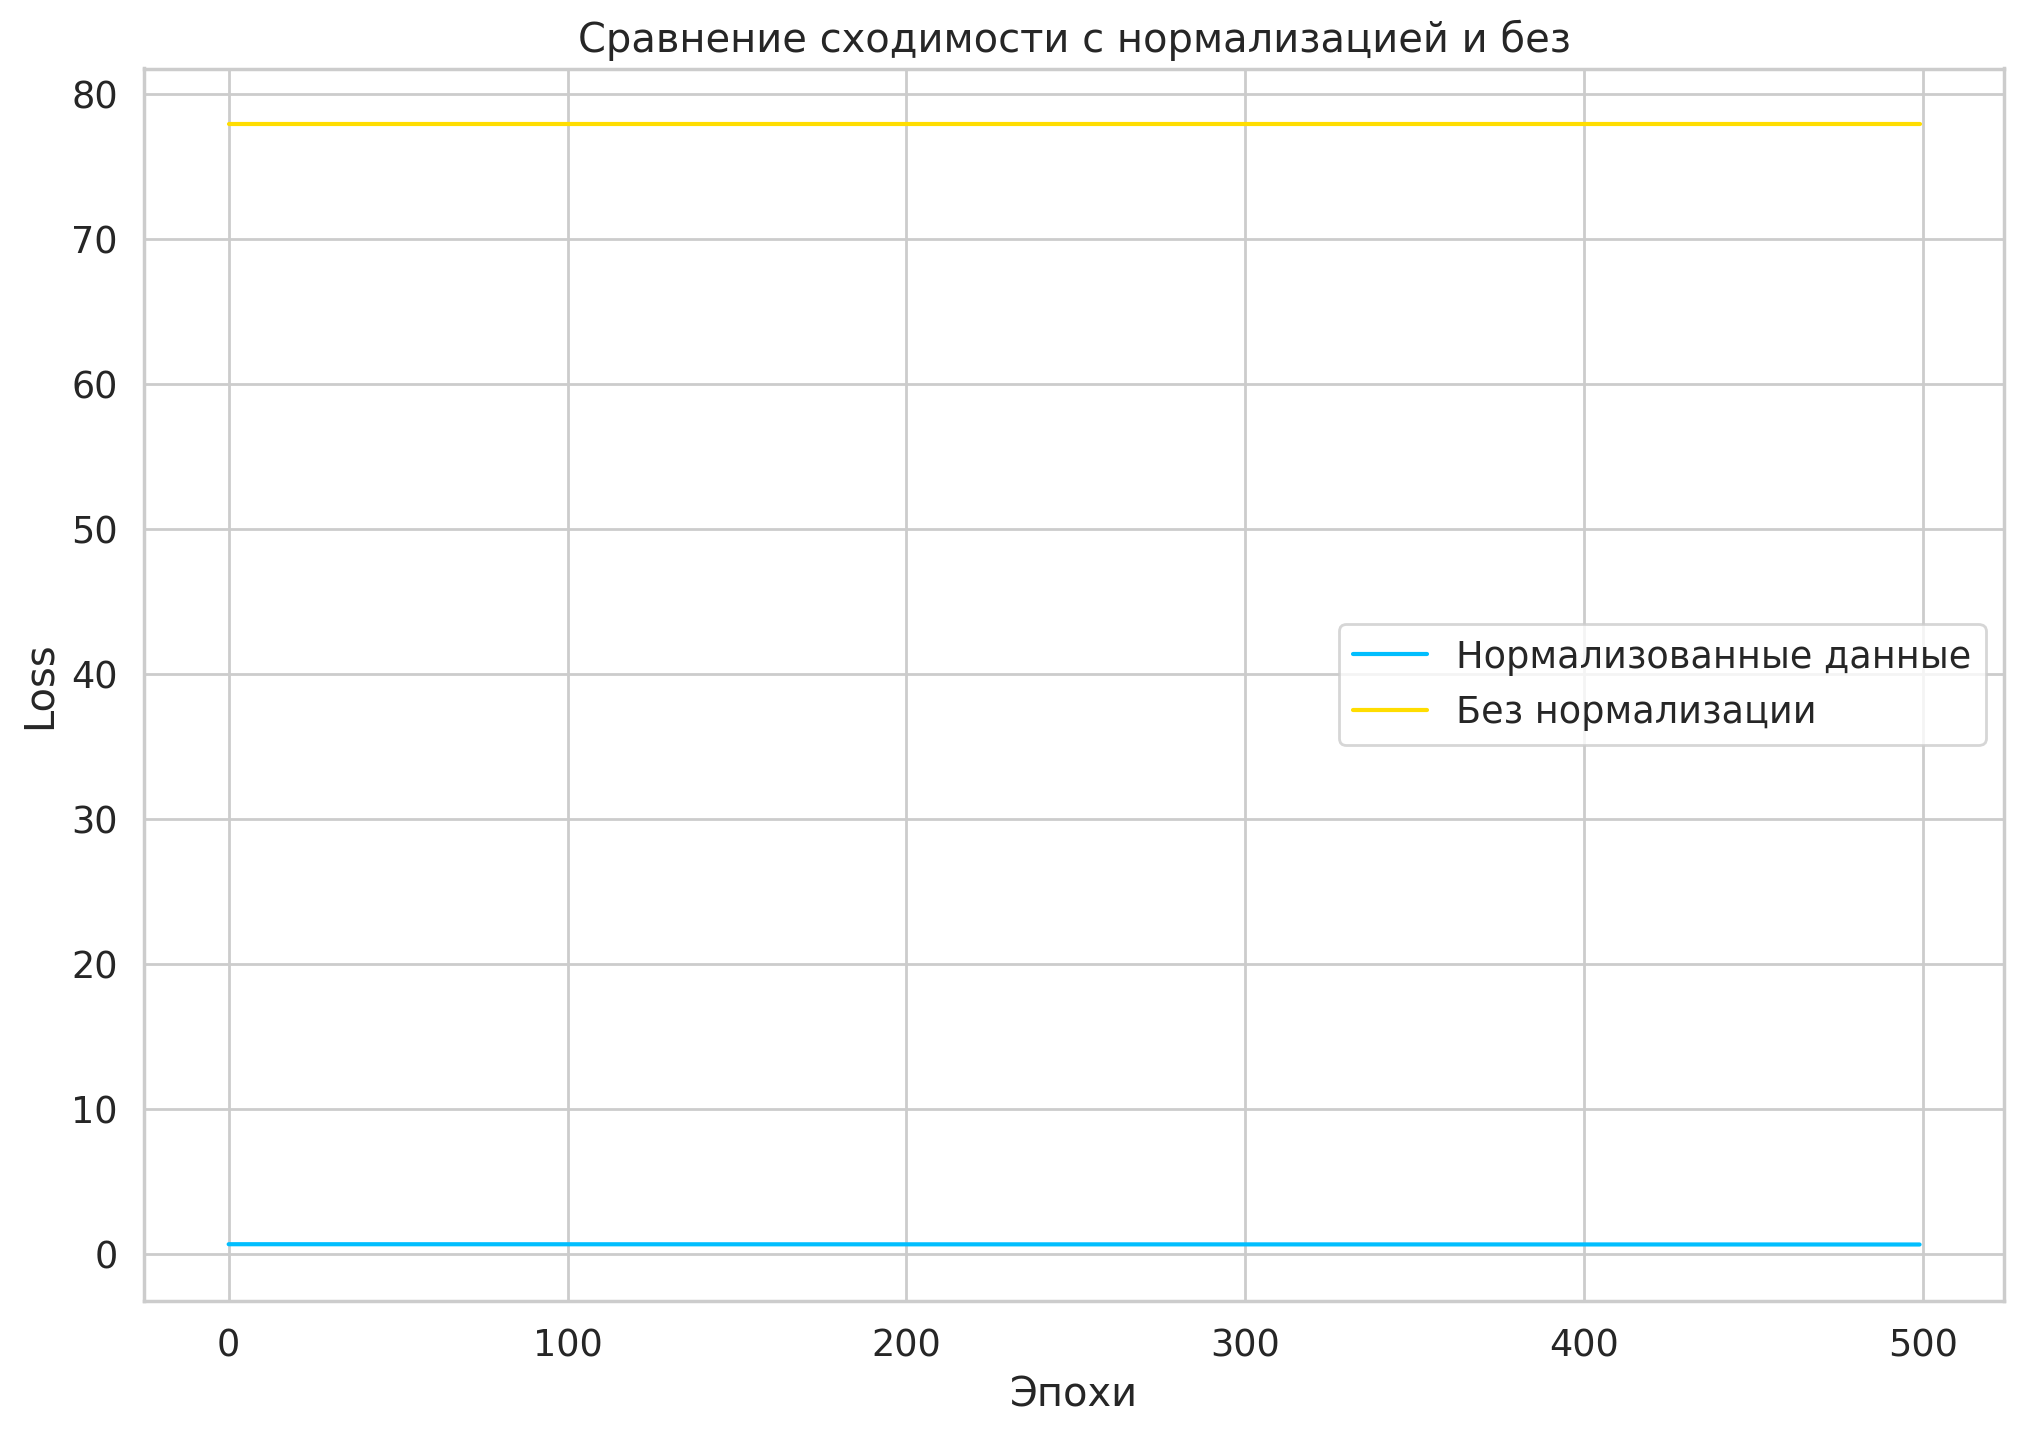

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = torch.from_numpy(scaler.fit_transform(X_train)).float()
X_test_scaled = torch.from_numpy(scaler.transform(X_test)).float()

# Используем ту же сеть, но с нормализованными данными
net = Net(4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

losses_scaled = []
for epoch in range(500):
    y_pred = net(X_train_scaled).squeeze()
    train_loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    losses_scaled.append(train_loss.item())

plt.plot(losses_scaled, label="Нормализованные данные")
plt.plot(results[0.0001], label="Без нормализации")
plt.title("Сравнение сходимости с нормализацией и без")
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()


#3 задание

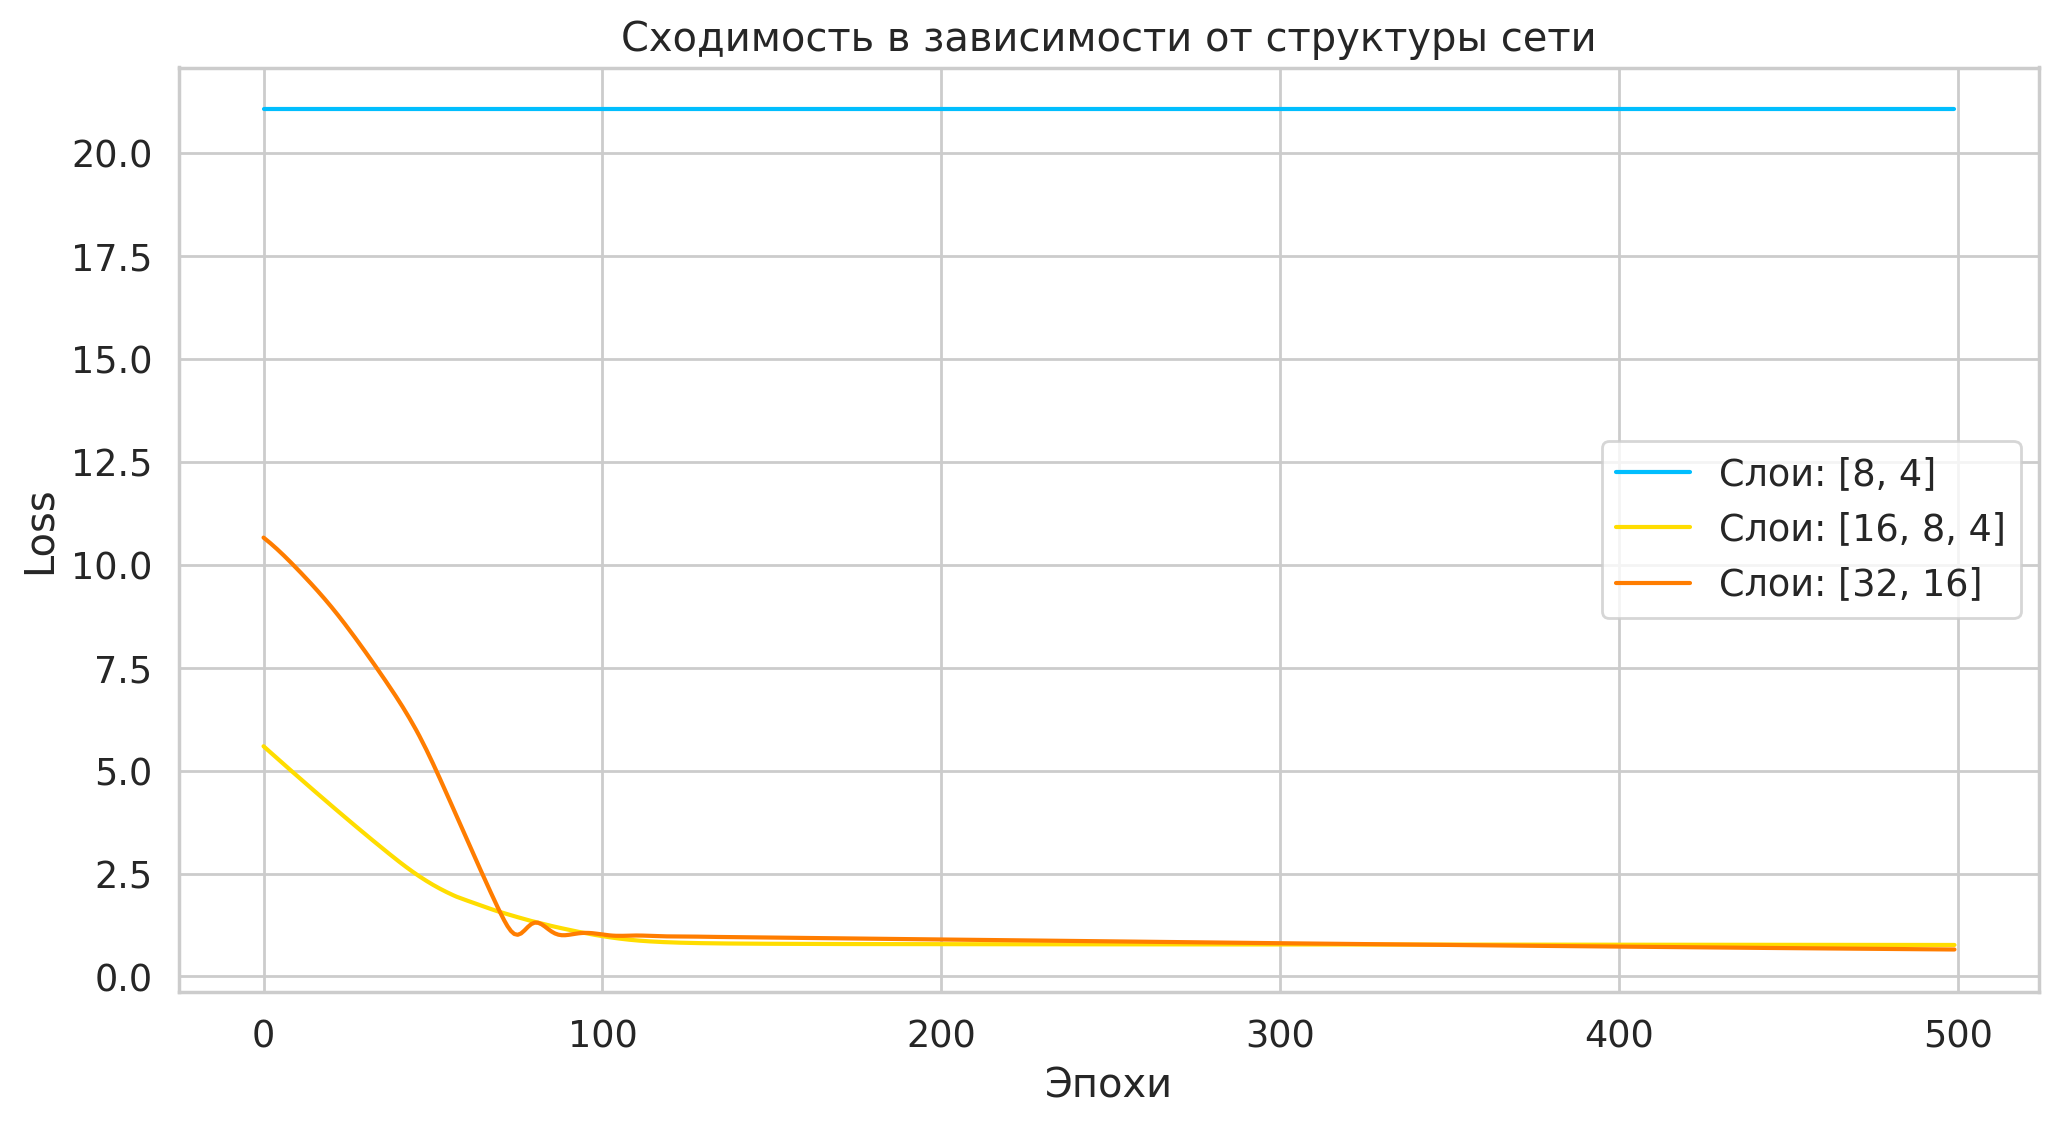

In [24]:
layer_configs = [
    [8, 4],  # базовая структура
    [16, 8, 4],  # больше слоёв
    [32, 16],  # меньше слоёв, больше нейронов
]

results_layers = {}

for config in layer_configs:
    class FlexibleNet(nn.Module):
        def __init__(self, config):
            super(FlexibleNet, self).__init__()
            layers = []
            input_size = 4
            for size in config:
                layers.append(nn.Linear(input_size, size))
                layers.append(nn.ReLU())
                input_size = size
            layers.append(nn.Linear(input_size, 1))
            layers.append(nn.Sigmoid())
            self.net = nn.Sequential(*layers)

        def forward(self, x):
            return self.net(x)

    net = FlexibleNet(config).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    losses = []
    for epoch in range(500):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        losses.append(train_loss.item())

    results_layers[str(config)] = losses

# Построение графиков
plt.figure(figsize=(12, 6))
for config, loss in results_layers.items():
    plt.plot(loss, label=f"Слои: {config}")
plt.title("Сходимость в зависимости от структуры сети")
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()


#4 задание

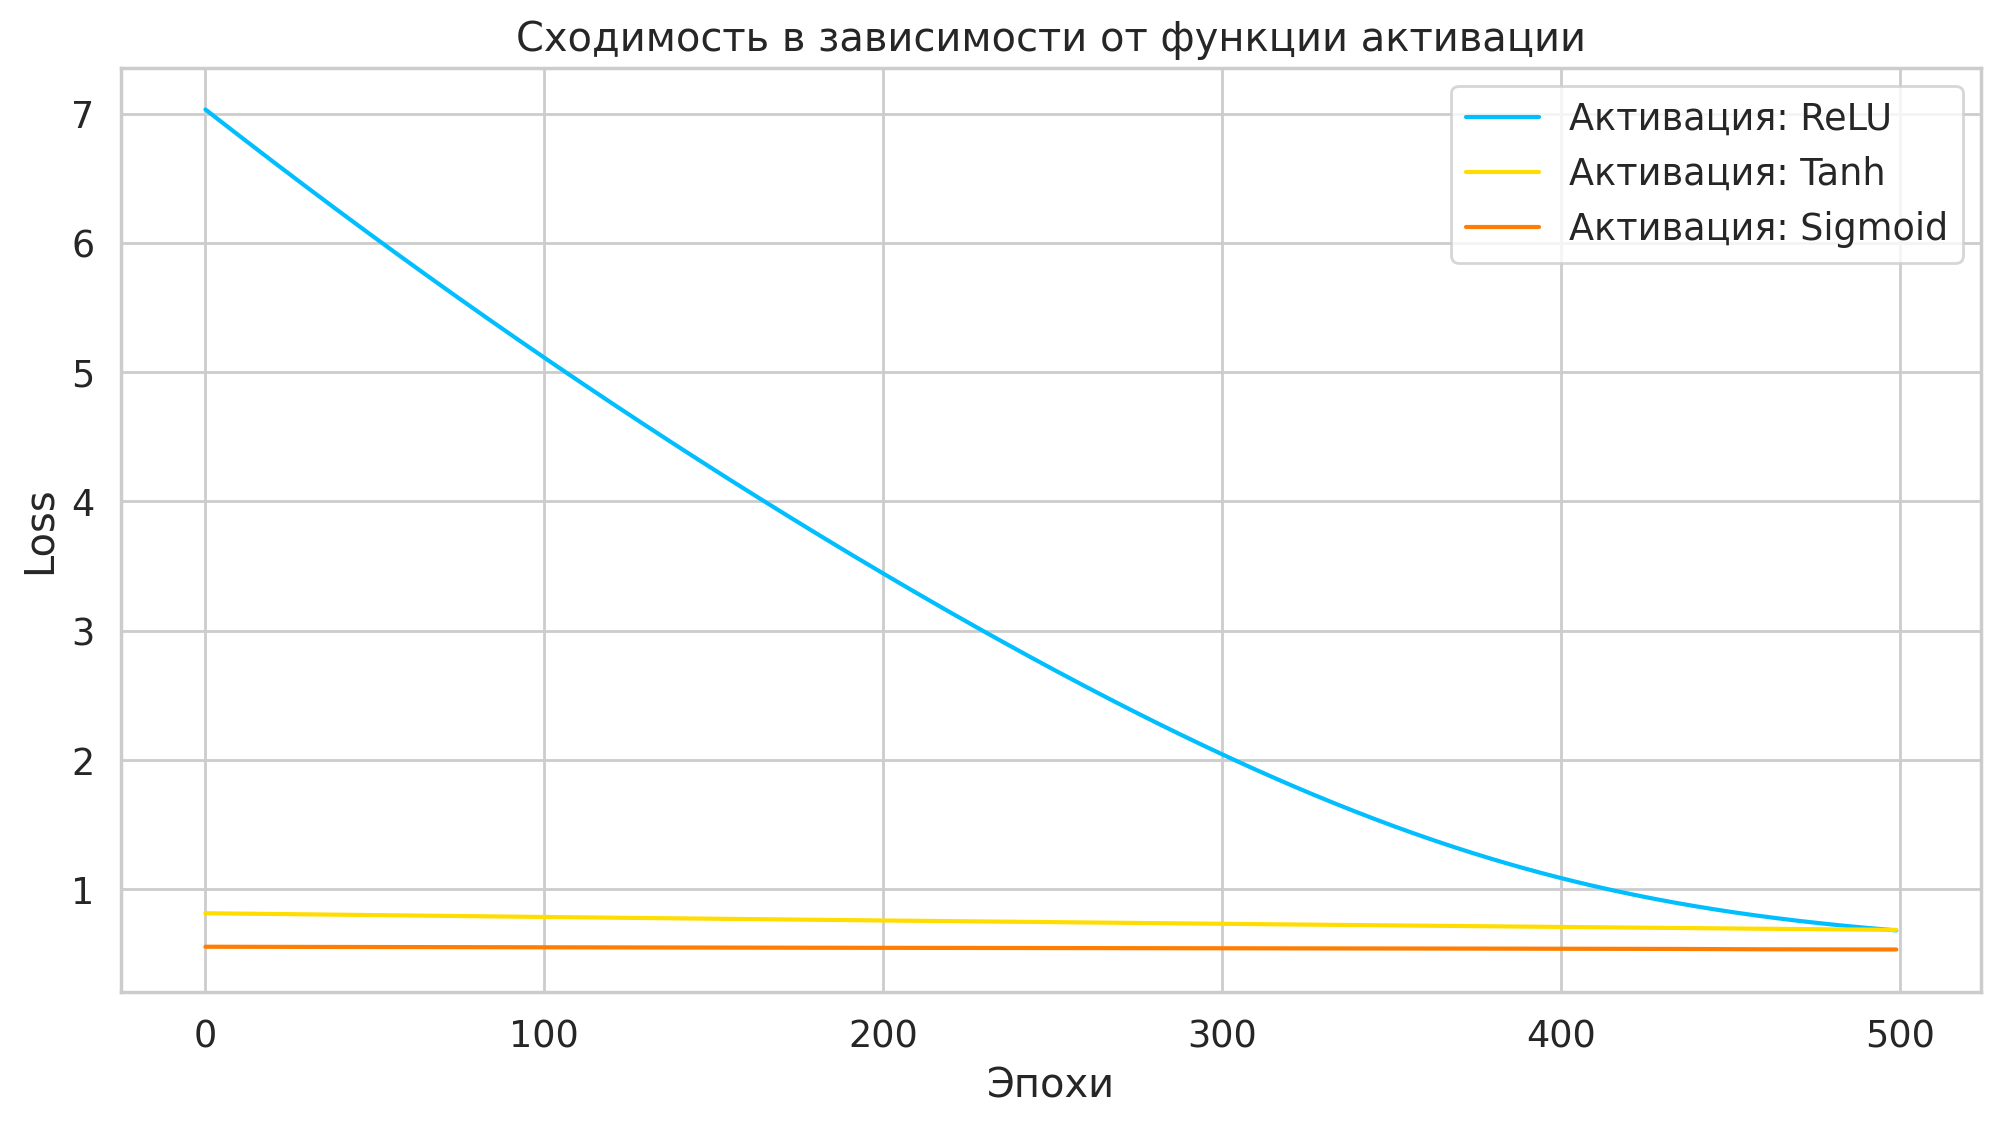

In [25]:
activations = {
    "ReLU": nn.ReLU,
    "Tanh": nn.Tanh,
    "Sigmoid": nn.Sigmoid,
}

results_activations = {}

for name, activation in activations.items():
    class ActivationNet(nn.Module):
        def __init__(self):
            super(ActivationNet, self).__init__()
            self.fc1 = nn.Linear(4, 8)
            self.fc2 = nn.Linear(8, 4)
            self.fc3 = nn.Linear(4, 1)
            self.activation = activation()

        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.activation(self.fc2(x))
            return torch.sigmoid(self.fc3(x))

    net = ActivationNet().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    losses = []
    for epoch in range(500):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        losses.append(train_loss.item())

    results_activations[name] = losses

# Построение графиков
plt.figure(figsize=(12, 6))
for name, loss in results_activations.items():
    plt.plot(loss, label=f"Активация: {name}")
plt.title("Сходимость в зависимости от функции активации")
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()


#5 задание

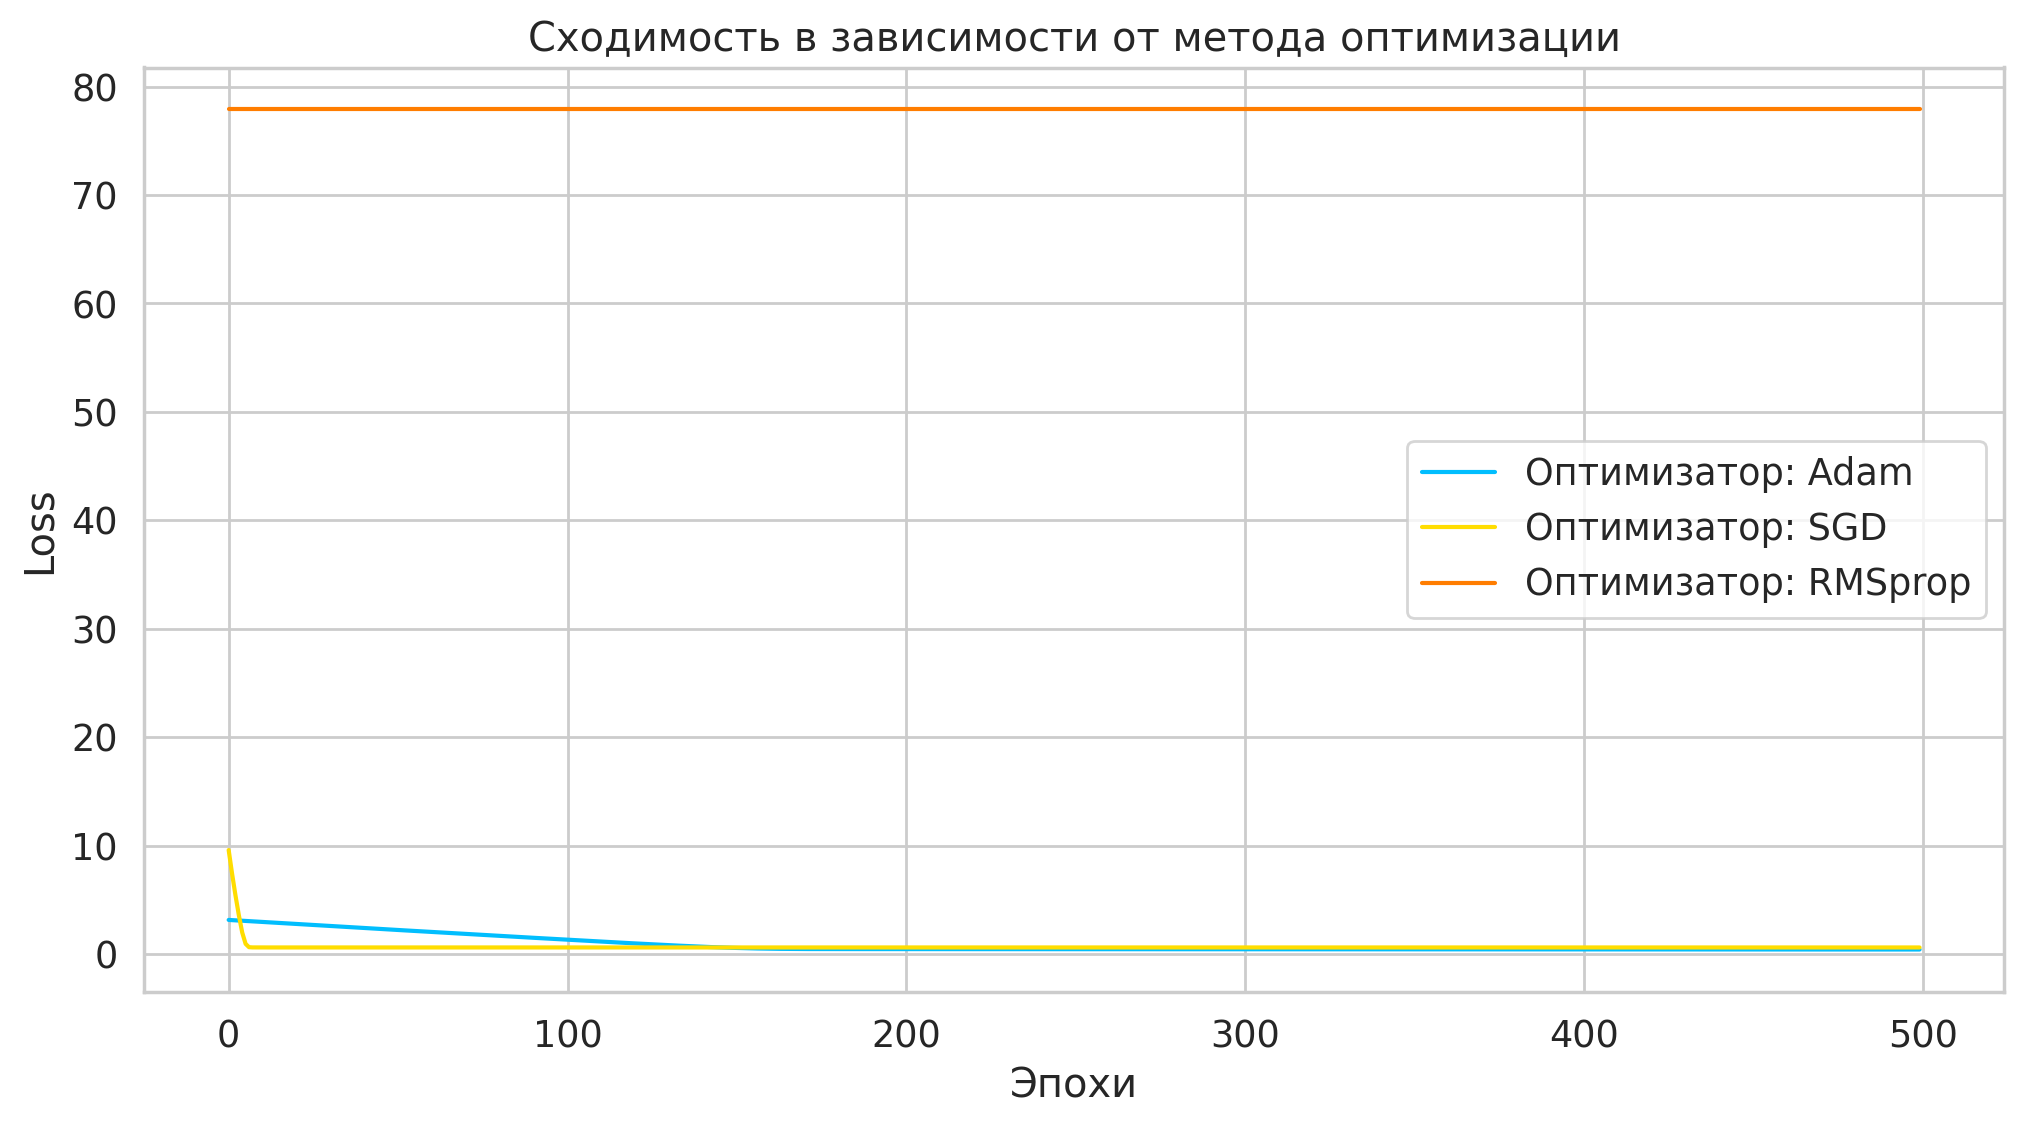

In [31]:
optimizers = {
    "Adam": optim.Adam,
    "SGD": optim.SGD,
    "RMSprop": optim.RMSprop,
}

results_optimizers = {}

for name, opt in optimizers.items():
    net = Net(4).to(device)
    optimizer = opt(net.parameters(), lr=0.0001)

    losses = []
    for epoch in range(500):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        losses.append(train_loss.item())

    results_optimizers[name] = losses

plt.figure(figsize=(12, 6))
for name, loss in results_optimizers.items():
    plt.plot(loss, label=f"Оптимизатор: {name}")
plt.title("Сходимость в зависимости от метода оптимизации")
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()


#6 задание

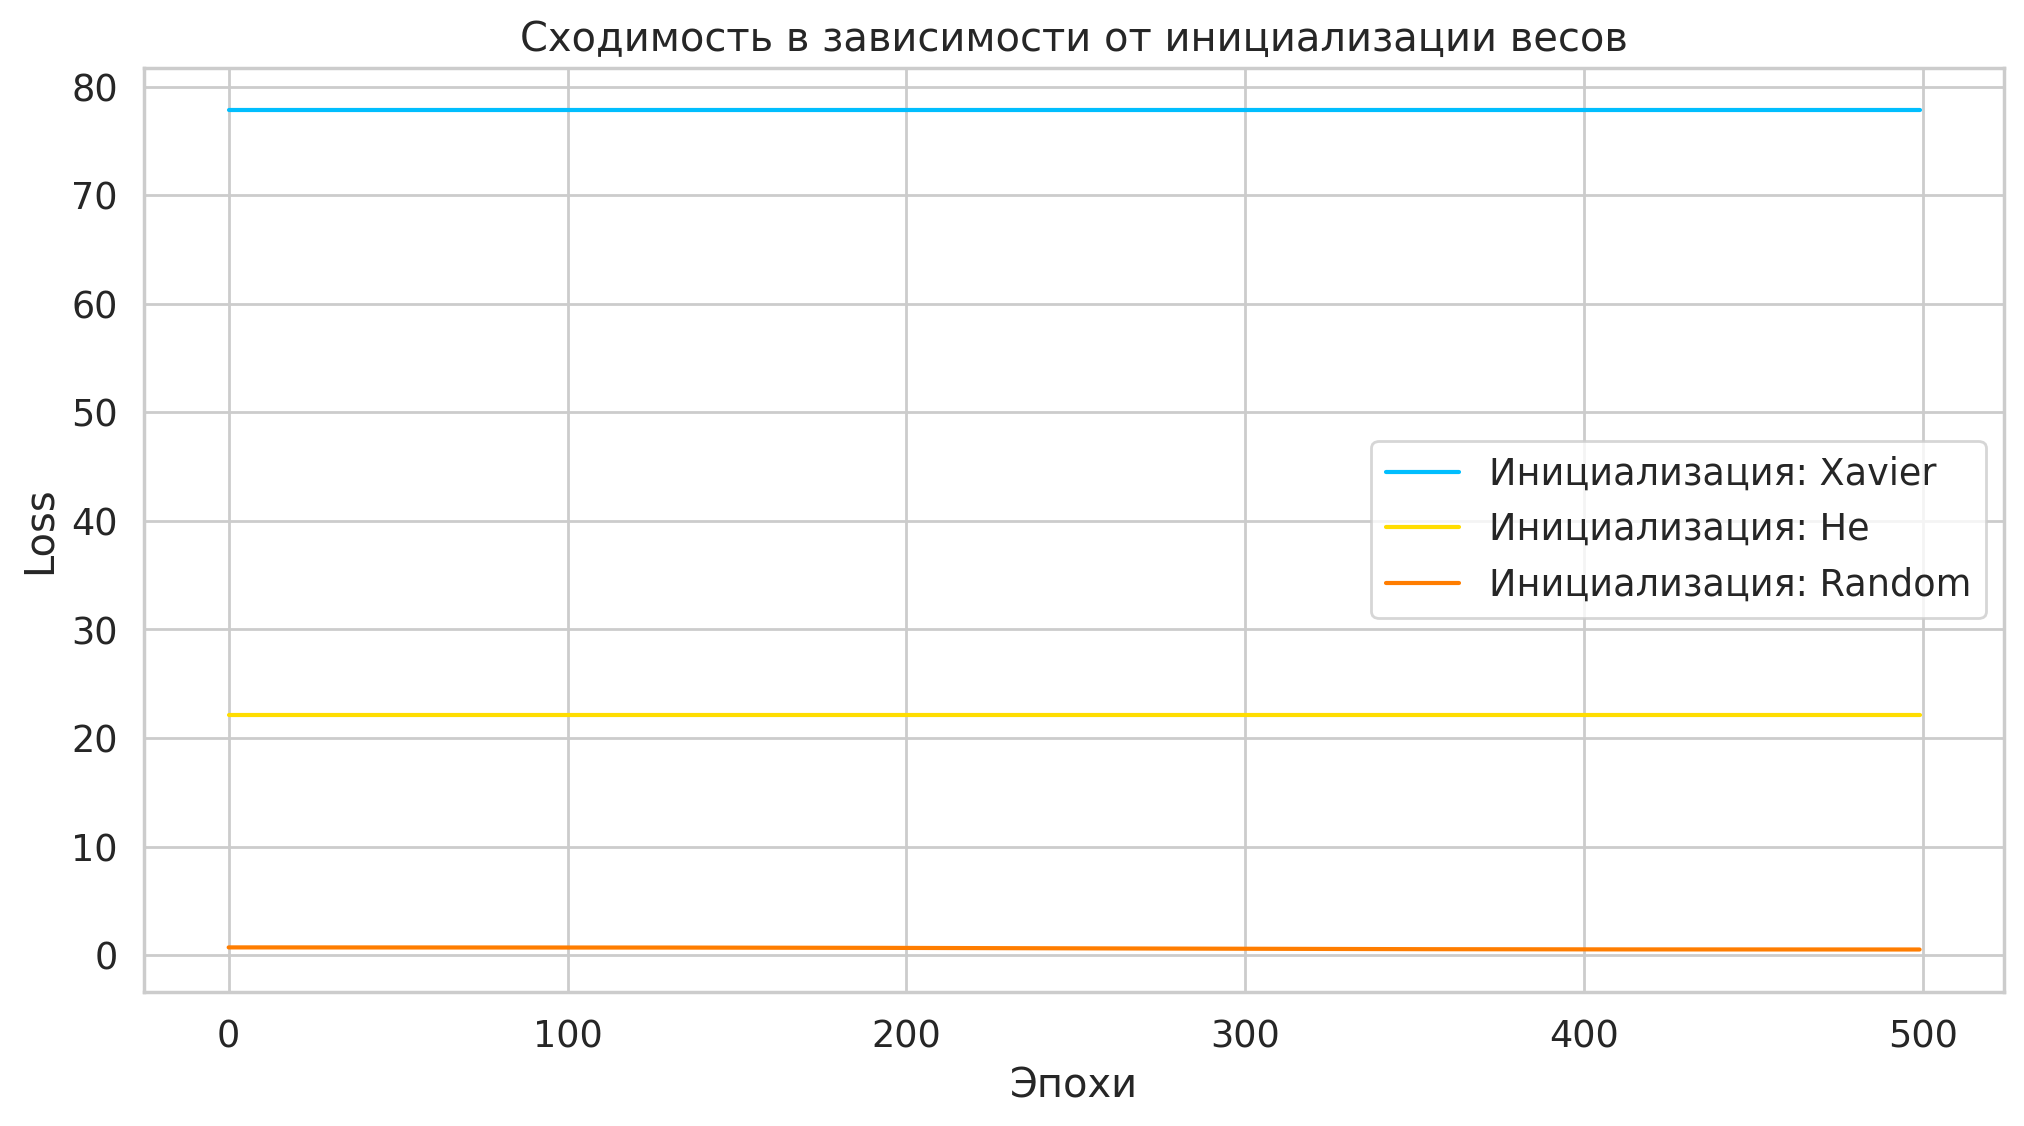

In [27]:
from torch.nn.init import xavier_uniform_, kaiming_uniform_, normal_

initializations = {
    "Xavier": xavier_uniform_,
    "He": kaiming_uniform_,
    "Random": lambda w: normal_(w, mean=0, std=0.01),
}

results_initializations = {}

for name, init in initializations.items():
    class InitNet(Net):
        def __init__(self):
            super(InitNet, self).__init__(4)
            init(self.fc1.weight)
            init(self.fc2.weight)
            init(self.fc3.weight)

    net = InitNet().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    losses = []
    for epoch in range(500):
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        losses.append(train_loss.item())

    results_initializations[name] = losses

plt.figure(figsize=(12, 6))
for name, loss in results_initializations.items():
    plt.plot(loss, label=f"Инициализация: {name}")
plt.title("Сходимость в зависимости от инициализации весов")
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.show()
